In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from nltk.corpus import wordnet, stopwords
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import matplotlib.pyplot as plt

In [2]:
encoding = 'latin1'
cards_cleaned = pd.read_csv('cards_cleaned.csv', encoding=encoding)

In [3]:
cards_cleaned.head(5)

,card_id,playerClass,type,name,set,text,mana cost,attack,health,rarity,collectible,flavor,sentiment
0,AT_132,NEUTRAL,MINION,Justicar Trueheart,TGT,<b>Battlecry:</b> Replace your starting Hero P...,6,6,3,LEGENDARY,True,It's like putting racing stripes and a giant s...,very positive
1,AT_131,NEUTRAL,MINION,Eydis Darkbane,TGT,Whenever <b>you</b> target this minion with a ...,3,3,4,LEGENDARY,True,"HATES being called ""the wonder twins"".",very negative
2,EX1_583,NEUTRAL,MINION,Priestess of Elune,EXPERT1,<b>Battlecry:</b> Restore 4 Health to your hero.,6,5,4,COMMON,True,"If she threatens to ""moon"" you, it's not what ...",negative
3,CFM_095,NEUTRAL,MINION,Weasel Tunneler,GANGS,<b>Deathrattle:</b> Shuffle this minion into y...,1,1,1,EPIC,True,He's the reason the First Bank of Gadgetzan ha...,positive
4,BRM_018,PALADIN,MINION,Dragon Consort,BRM,<b>Battlecry:</b> The next Dragon you play cos...,5,5,5,RARE,True,Everybody wants someone to snuggle with. Even ...,very negative


Natural Language Processing (NLP) on cards text.

In [4]:
# extracting column 'text'
text = cards_cleaned[['text']]
text.head(5)

,text
0,<b>Battlecry:</b> Replace your starting Hero P...
1,Whenever <b>you</b> target this minion with a ...
2,<b>Battlecry:</b> Restore 4 Health to your hero.
3,<b>Deathrattle:</b> Shuffle this minion into y...
4,<b>Battlecry:</b> The next Dragon you play cos...


In [5]:
text.isna().sum()

text    0
dtype: int64

In [6]:
# Tokenization, lowercasing, removing punctuation
def tokenizer_and_remove_punctuation(row):
    text_value = row['text']
    tokens = word_tokenize(text_value)
    return [word.lower() for word in tokens if word.isalpha()]

# Assuming 'text' is the name of the DataFrame and 'text' is the name of the column
text['tokenized'] = text.apply(tokenizer_and_remove_punctuation, axis=1)
text.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6136\2502347848.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['tokenized'] = text.apply(tokenizer_and_remove_punctuation, axis=1)


,text,tokenized
0,<b>Battlecry:</b> Replace your starting Hero P...,"[b, battlecry, replace, your, starting, hero, ..."
1,Whenever <b>you</b> target this minion with a ...,"[whenever, b, you, target, this, minion, with,..."
2,<b>Battlecry:</b> Restore 4 Health to your hero.,"[b, battlecry, restore, health, to, your, hero]"
3,<b>Deathrattle:</b> Shuffle this minion into y...,"[b, deathrattle, shuffle, this, minion, into, ..."
4,<b>Battlecry:</b> The next Dragon you play cos...,"[b, battlecry, the, next, dragon, you, play, c..."


In [7]:
# get wordet POS
# Function to map POS tag to first character lemmatize() accepts
def get_wordnet_pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Default to noun if the POS tag is not one of the known types

In [8]:
# Lemmatization using POS tags
lemmatizer = WordNetLemmatizer()

def lemmatizer_with_pos(row):
  return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in row['tokenized']]

text['lemmatized'] = text.apply(lemmatizer_with_pos, axis=1) # This one will take a while
text.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6136\328473762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['lemmatized'] = text.apply(lemmatizer_with_pos, axis=1) # This one will take a while


,text,tokenized,lemmatized
0,<b>Battlecry:</b> Replace your starting Hero P...,"[b, battlecry, replace, your, starting, hero, ...","[b, battlecry, replace, your, starting, hero, ..."
1,Whenever <b>you</b> target this minion with a ...,"[whenever, b, you, target, this, minion, with,...","[whenever, b, you, target, this, minion, with,..."
2,<b>Battlecry:</b> Restore 4 Health to your hero.,"[b, battlecry, restore, health, to, your, hero]","[b, battlecry, restore, health, to, your, hero]"
3,<b>Deathrattle:</b> Shuffle this minion into y...,"[b, deathrattle, shuffle, this, minion, into, ...","[b, deathrattle, shuffle, this, minion, into, ..."
4,<b>Battlecry:</b> The next Dragon you play cos...,"[b, battlecry, the, next, dragon, you, play, c...","[b, battlecry, the, next, dragon, you, play, c..."


In [9]:
# Custom stop word
custom_stop_word = 'b'

# Assuming 'text' is the name of the DataFrame and 'lemmatized' is the name of the column
def remove_sw(row):
    lemmatized_tokens = row['lemmatized']
    
    # Add custom stop word 'b'
    stop_words = set(stopwords.words('english'))
    stop_words.add(custom_stop_word)
    
    # Remove stopwords including the custom stop word
    no_stopwords = [word for word in lemmatized_tokens if word not in stop_words]
    return no_stopwords

text['no_stopwords'] = text.apply(remove_sw, axis=1)
text.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6136\4064909100.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['no_stopwords'] = text.apply(remove_sw, axis=1)


,text,tokenized,lemmatized,no_stopwords
0,<b>Battlecry:</b> Replace your starting Hero P...,"[b, battlecry, replace, your, starting, hero, ...","[b, battlecry, replace, your, starting, hero, ...","[battlecry, replace, starting, hero, power, be..."
1,Whenever <b>you</b> target this minion with a ...,"[whenever, b, you, target, this, minion, with,...","[whenever, b, you, target, this, minion, with,...","[whenever, target, minion, spell, deal, damage..."
2,<b>Battlecry:</b> Restore 4 Health to your hero.,"[b, battlecry, restore, health, to, your, hero]","[b, battlecry, restore, health, to, your, hero]","[battlecry, restore, health, hero]"
3,<b>Deathrattle:</b> Shuffle this minion into y...,"[b, deathrattle, shuffle, this, minion, into, ...","[b, deathrattle, shuffle, this, minion, into, ...","[deathrattle, shuffle, minion, opponent, deck]"
4,<b>Battlecry:</b> The next Dragon you play cos...,"[b, battlecry, the, next, dragon, you, play, c...","[b, battlecry, the, next, dragon, you, play, c...","[battlecry, next, dragon, play, cost, le]"


In [10]:
# Re-creating the sentences with the preprocessed text
def recreate_sentences(row):
  return " ".join(row['no_stopwords'])

text['clean_text'] = text.apply(recreate_sentences, axis=1)
text.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6136\2938054903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['clean_text'] = text.apply(recreate_sentences, axis=1)


,text,tokenized,lemmatized,no_stopwords,clean_text
0,<b>Battlecry:</b> Replace your starting Hero P...,"[b, battlecry, replace, your, starting, hero, ...","[b, battlecry, replace, your, starting, hero, ...","[battlecry, replace, starting, hero, power, be...",battlecry replace starting hero power better one
1,Whenever <b>you</b> target this minion with a ...,"[whenever, b, you, target, this, minion, with,...","[whenever, b, you, target, this, minion, with,...","[whenever, target, minion, spell, deal, damage...",whenever target minion spell deal damage rando...
2,<b>Battlecry:</b> Restore 4 Health to your hero.,"[b, battlecry, restore, health, to, your, hero]","[b, battlecry, restore, health, to, your, hero]","[battlecry, restore, health, hero]",battlecry restore health hero
3,<b>Deathrattle:</b> Shuffle this minion into y...,"[b, deathrattle, shuffle, this, minion, into, ...","[b, deathrattle, shuffle, this, minion, into, ...","[deathrattle, shuffle, minion, opponent, deck]",deathrattle shuffle minion opponent deck
4,<b>Battlecry:</b> The next Dragon you play cos...,"[b, battlecry, the, next, dragon, you, play, c...","[b, battlecry, the, next, dragon, you, play, c...","[battlecry, next, dragon, play, cost, le]",battlecry next dragon play cost le


In [11]:
text.shape

(1024, 5)

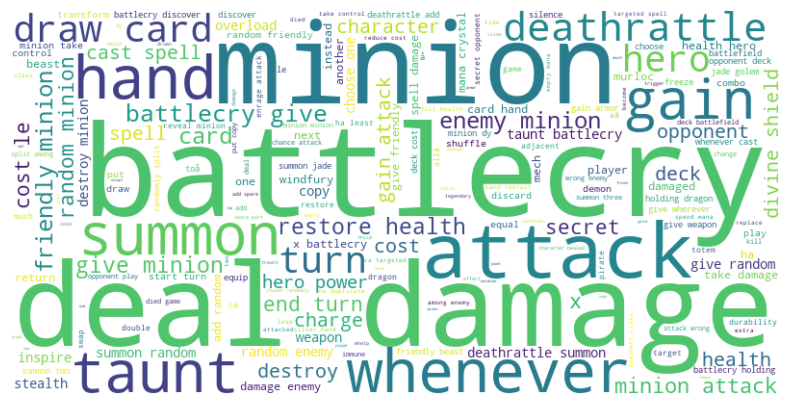

In [12]:
# creating word cloud

text_data = ' '.join(text['no_stopwords'].explode().dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# vectorization
# will take 300 common words
bow_vect = CountVectorizer(max_features=1000)
# Fit transform creates one entry for each different word seen
X = bow_vect.fit_transform(text['clean_text']).toarray()
as_df = pd.DataFrame(X, columns=bow_vect.get_feature_names_out())
as_df.head()

,add,addâ,adjacent,adjacentâ,allâ,already,also,always,ambush,among,...,whelp,whenever,wherever,whomever,windfury,wisp,withâ,wolf,wrong,yourâ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#clusterring
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=100)
kmeans.fit(X)
pred = kmeans.predict(X)

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Administrator\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Administrator\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Administrator\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as pr

In [15]:
pred

array([1, 4, 1, ..., 0, 1, 4])

In [16]:
predict_df = pd.concat([text['text'].reset_index(drop=True), pd.DataFrame(pred, columns=['class'])], axis=1)
predict_df.head()

,text,class
0,<b>Battlecry:</b> Replace your starting Hero P...,1
1,Whenever <b>you</b> target this minion with a ...,4
2,<b>Battlecry:</b> Restore 4 Health to your hero.,1
3,<b>Deathrattle:</b> Shuffle this minion into y...,0
4,<b>Battlecry:</b> The next Dragon you play cos...,1


In [17]:
predict_df[predict_df['class']==0]

,text,class
3,<b>Deathrattle:</b> Shuffle this minion into y...,0
5,Transform your minions into random minions tha...,0
8,Your minions cost (3) more.,0
17,Spend all your Mana. Summon a random minion th...,0
29,Choose an enemy minion. At the start of your t...,0
...,...,...
1005,Costs (1) less for each other minion on the ba...,0
1007,Add a copy of each damaged friendly minion to ...,0
1009,Destroy 2 random enemy minions. Discard 2 rand...,0
1014,Minions with <b>Battlecry</b> cost (2) more.,0


In [18]:
predict_df[predict_df['class']==1]

,text,class
0,<b>Battlecry:</b> Replace your starting Hero P...,1
2,<b>Battlecry:</b> Restore 4 Health to your hero.,1
4,<b>Battlecry:</b> The next Dragon you play cos...,1
6,<b>Taunt</b>. <b>Choose One -</b>\n+1 Attack; ...,1
9,"<b>Battlecry:</b> If you're holding a Dragon, ...",1
...,...,...
1000,"At the end of your turn, restore 1 Health to y...",1
1004,<b>Battlecry:</b> Destroy a Beast.,1
1015,<b>Deathrattle:</b> Restore 5 Health to the en...,1
1019,"Whenever you cast a spell, add a 'Fireball' sp...",1


In [19]:
predict_df[predict_df['class']==4]

,text,class
1,Whenever <b>you</b> target this minion with a ...,4
7,Deal $5 damage to all characters.,4
10,Deal $5 damage. Summon a random\n5-Cost minion.,4
19,"Whenever a character is healed, deal 1 damage ...",4
27,<b>Battlecry:</b> Deal 1 damage.,4
...,...,...
1011,<b>Battlecry:</b> Deal 3 damage randomly split...,4
1012,Deal $2 damage. Restore #2 Health to your hero.,4
1017,[x]<b>Deathrattle:</b> Deal 2 damage\nto the e...,4
1020,Deal $5 damage. Restore #5 Health to your hero.,4


In [20]:
predict_df[predict_df['class']==2]

,text,class
11,Give a Demon +3/+3. Give your opponent a Mana ...,2
13,Give a minion <b>Windfury</b>.,2
14,<b>Deathrattle:</b> Give a random friendly min...,2
21,"After you summon a minion, give it +1/+1.",2
22,<b>Inspire:</b> Give your other minions +1/+1.,2
...,...,...
977,"At the end of your turn, give your C'Thun +1/+...",2
980,<b>Battlecry:</b> Give a minion -2 Attack this...,2
996,<b>Battlecry:</b> Give a random Beast in your ...,2
1013,Give your hero +4Â Attack this turn.,2


In [22]:
predict_df[predict_df['class']==5]

,text,class
43,"Whenever your opponent casts a spell, gain +2 ...",5
45,"Whenever a friendly Mech dies, gain +2/+2.",5
58,<b>Battlecry:</b> Destroy a Murloc and gain +2...,5
60,<b>Battlecry:</b> Choose a friendly minion. Ga...,5
69,Whenever <b>you</b> target this minion with a ...,5
...,...,...
983,"Whenever a friendly minion dies, gain +1 Attack.",5
993,<b>Inspire:</b> Gain <b>Windfury</b>\nthis turn.,5
997,<b>Taunt</b>\n<b>Battlecry:</b> Gain +1/+1 for...,5
1008,Unlimited attacks each turn. Can't attack heroes.,5


In [25]:
predict_df[predict_df['class']==3]

,text,class
18,Deal $3 damage.\nDraw a card.,3
25,<b>Battlecry and Deathrattle:</b> Add a <b>Spa...,3
26,<b>Choose One -</b> Summon a{1} {0} <b>Jade Go...,3
64,Costs (1) less for each card in your opponent'...,3
80,<b>Battlecry:</b> Add a random Paladin card to...,3
...,...,...
992,Your cards cost (5).,3
995,Draw cards until you have as many in hand as y...,3
998,"<b>Battlecry:</b> <b>Discover</b> a Druid, Rog...",3
1002,"[x]<b>Stealth</b>. Whenever this\nattacks, add...",3


Group analysis:

Group 0: Describes various card effects or abilities in Hearthstone, including summoning minions, modifying mana costs, or triggering specific actions under certain conditions.

Group 1: Contains card descriptions with "Battlecry" effects, activating specific abilities when the card is played onto the board in Hearthstone.

Group 2: Describes cards that enhance or modify specific types of creatures or entities in Hearthstone, such as Demons or minions, providing buffs, debuffs, or other modifications.

Group 3: Involves cards with effects related to drawing cards, reducing costs, or summoning specific entities in Hearthstone, aiding players in deck management and resource utilization.

Group 4: Features cards with effects triggered by specific conditions like dealing damage or benefiting from certain actions, offering strategic opportunities during gameplay in Hearthstone.

Group 5: Contains cards with effects triggered by specific events or conditions such as opponent actions or friendly minion deaths, allowing players to adapt their strategy based on the evolving game state in Hearthstone.


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

text_data = cards_cleaned['text'].astype(str).tolist()

# Use CountVectorizer to convert text data into a document-term matrix (dtm)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(text_data)

# Fit LDA model
num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Display the top words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Topic #{i+1}: {', '.join([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])}")

Topic #1: takes, deck, opponent, enemy, hero, battlecry, spell, minion, deal, damage
Topic #2: divine, minions, shield, taunt, weapon, charge, minion, attack, gain, battlecry
Topic #3: end, destroy, hero, restore, battlecry, attack, friendly, turn, health, minion
Topic #4: opponent, add, draw, minion, battlecry, card, deathrattle, random, summon, hand
Topic #5: deck, deathrattle, enemy, battlecry, costs, summon, deal, damage, taunt, minions
